In [1]:
from math import ceil

import joblib
import os 
import glob
import matplotlib.pyplot as plt
from pprint import pprint
%matplotlib notebook

In [2]:
def open_simulation_files(simulation_folder):
    pprint(os.path.join(simulation_folder, 'test_record.jbl'))
    test = joblib.load(os.path.join(simulation_folder, 'test_record.jbl'))
    simulation = joblib.load(os.path.join(simulation_folder, 'simulation_params.jbl'))
    goal_sampler = joblib.load(os.path.join(simulation_folder, 'goal_sampler_record.jbl'))    
    # log = joblib.load(os.path.join(simulation, 'log.log'))
    return test, simulation, goal_sampler

def load_simulation(simulation):
    test_record, simulation_params, goal_sampler_record = open_simulation_files(simulation)
    episodes = list(test_record.keys())
    flattened_record = flatten(test_record)
#     pprint(test_record)

    goal_records = goal_sampler_record['goals_record']
    reached_counter = {k:v['reached_counter'] for k,v in goal_records.items()}
    target_counter = {k:v['target_counter'] for k,v in goal_records.items()}
    discovery_records = {k:v['iter_discovery'] for k,v in goal_records.items()}
    return flattened_record, reached_counter, target_counter, discovery_records, episodes

def load_simulation_list(simulation_list):
    flattened_records = {}
    reached_counters = {}
    target_counters = {}
    discovery_records = {}
    for simulation in simulation_list:
        test_records, reached, target, discovery, episodes = load_simulation(simulation)
        
#         test_record, simulation_params, goal_sampler_record = open_simulation_files(simulation)
#         test_record = flatten(test_record)
        for k,v in test_records.items():
            try:
                flattened_records[k].append(v)
            except KeyError:
                flattened_records[k] = [v]
        
        for k in reached.keys():
            try:
                reached_counters[k].append(reached[k])
                target_counters[k].append(target[k])
                discovery_records[k].append(discovery[k])
            except KeyError:
                reached_counters[k] = [reached[k]]
                target_counters[k] = [target[k]]
                discovery_records[k] = [discovery[k]]
        print('done')

    for k, v in flattened_records.items():
        flattened_records[k] = np.array(v)
    
    return flattened_records, reached_counters, target_counters, discovery_records, episodes

In [11]:
def flatten(d):
    deal_with_overall_results(d)
    def aux(d, out):
        for k,v in d.items():
            if isinstance(v, dict):
                aux(v, out)
            else:
                try:
                    out[k].append(v)
                except KeyError:
                    out[k] = [v]
                    
    out = {}
    for val in d.values():
        if isinstance(val, dict):
            aux(val, out)
    return out

def replace_key(d, key, replace_by):
    try:
        v = d.pop(key)
        d[replace_by] = v
    except KeyError:
        pass
    

def deal_with_overall_results(d):
    thing_list = list(list(d.values())[0].keys())
    for v in d.values():
        for t in thing_list:
            replace_key(v[t], 'overall', f'overall_{t}')
            

In [5]:
def plot_average_success_rates(episodes, flattened_test_record, reached_counter, iter_discovery, ncols=3, std_record=None):
    nline = ceil(len(flattened_test_record) / ncols)
    fig, axes = plt.subplots(nline, ncols, figsize=(15,15), sharex=True, sharey=True)
    plt.subplots_adjust(hspace=0.6)
    i, j = 0, 0
    for k,v in flattened_test_record.items():
        ax = axes[i,j]
        ax.plot(episodes, v)
        if std_record:
            ax.fill_between(episodes, v-std_record[k], v+std_record[k], alpha=0.5)
        ax.set_title(k, pad=15)
        ax.set_ylim(0,1)
        try:
            ax.text(1, 0.85, f'pos. ex:{reached_counter[k]} \n'
                             f'disc:{iter_discovery[k]}',
                horizontalalignment='right',
                verticalalignment='bottom',
                transform=ax.transAxes)
        except KeyError:
            pass
        if j == ncols -1:
            j = 0
            i +=1
        else:
            j+=1
    #Delete unused axes
    while j < ncols:
        fig.delaxes(axes[i, j])
        j +=1

def plot_goal_record(reached_counter, target_counter):
    ind = np.arange(len(goal_records))  # the x locations for the groups
    width = 0.2     # the width of the bars

    fig, ax = plt.subplots(figsize=(20,5))
    ax.bar(ind, reached_counter.values(),width, color='r', label = 'reached_counter')
    ax.bar(ind+width, target_counter.values(),width, color='g', label = 'target_counter')

    ax.set_xticks(ind + width)
    ax.set_xticklabels(goal_records.keys())
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize='x-small')
    
    ax.legend()
    fig.tight_layout()
    
def load_and_plot(path):
    flattened_records, reached_counters, target_counters, discovery_records, episodes = load_simulation_list(path)
    reached_averaged = {k: (np.round(np.mean(v)),np.round(np.std(v), 1)) for k,v in reached_counters.items()}
    average_discovery = {k: (np.round(np.mean(v)),np.round(np.std(v), 1)) for k,v in discovery_records.items()}
    average_flattened = {k: np.mean(v, 0) for k,v in flattened_records.items()}
    std_flattened = {k: np.std(v, 0) for k,v in flattened_records.items()}
    plot_average_success_rates(episodes, average_flattened, reached_averaged, std_record=std_flattened, iter_discovery=average_discovery)          

In [14]:
# for g in glob.glob('results/simulation_<*'):
#     rep = g.split('_')[-2]
#     c = g.split("'")[-2].split('.')[-1]
#     os.rename(g, g.replace(rep, c))

# Plot one simulation

In [255]:
simulation_name = 'AttentionFlatQnet_7'
folders = glob.glob(f'results/simulation_{simulation_name}*')
print(folders)

['results/simulation_AttentionFlatQnet_7']


In [256]:
flattened_records, reached_counter, target_counter, discovery_records = load_simulation(folders[0])

'results/simulation_AttentionFlatQnet_7/test_record.jbl'


<IPython.core.display.Javascript object>


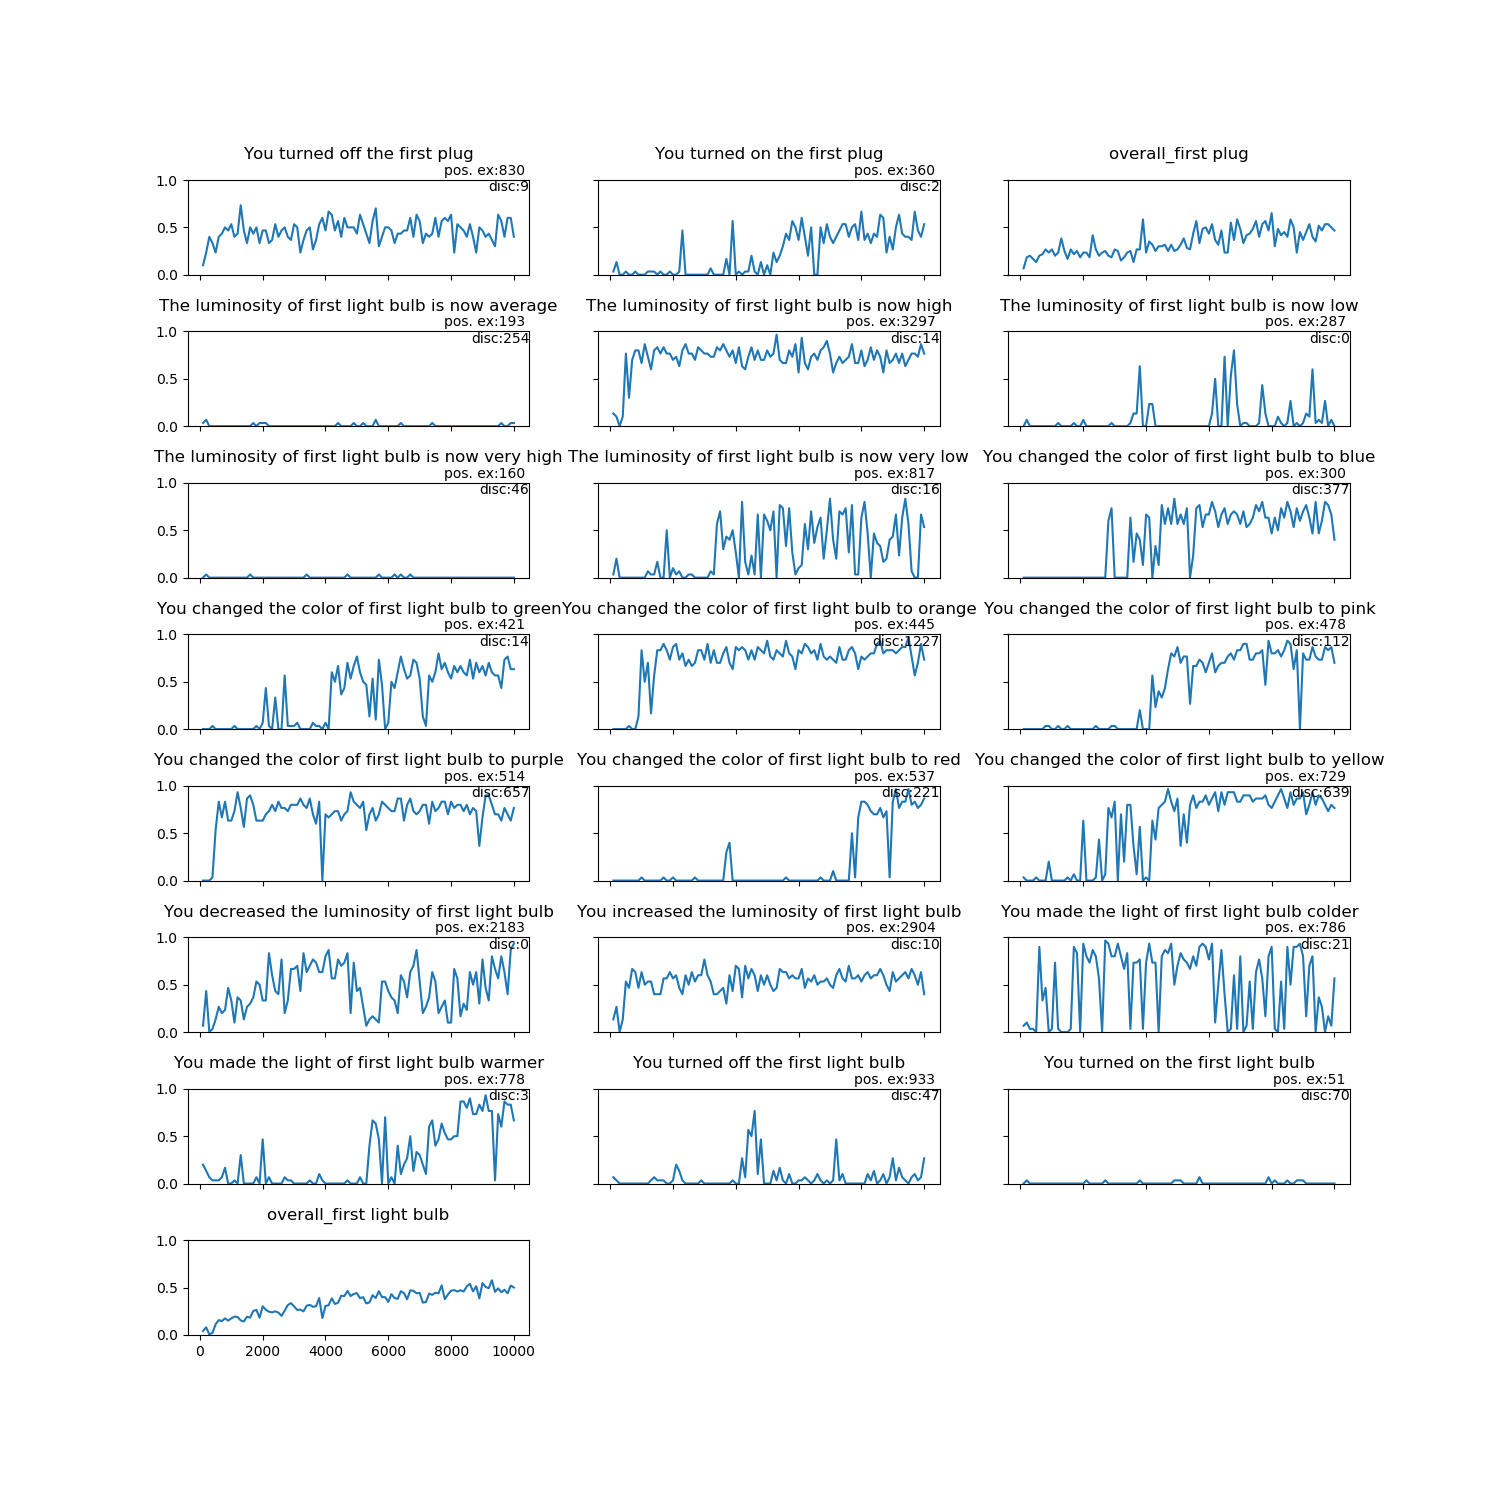

In [257]:
plot_average_success_rates(flattened_record, reached_counter, iter_discovery=discovery_records)

<IPython.core.display.Javascript object>


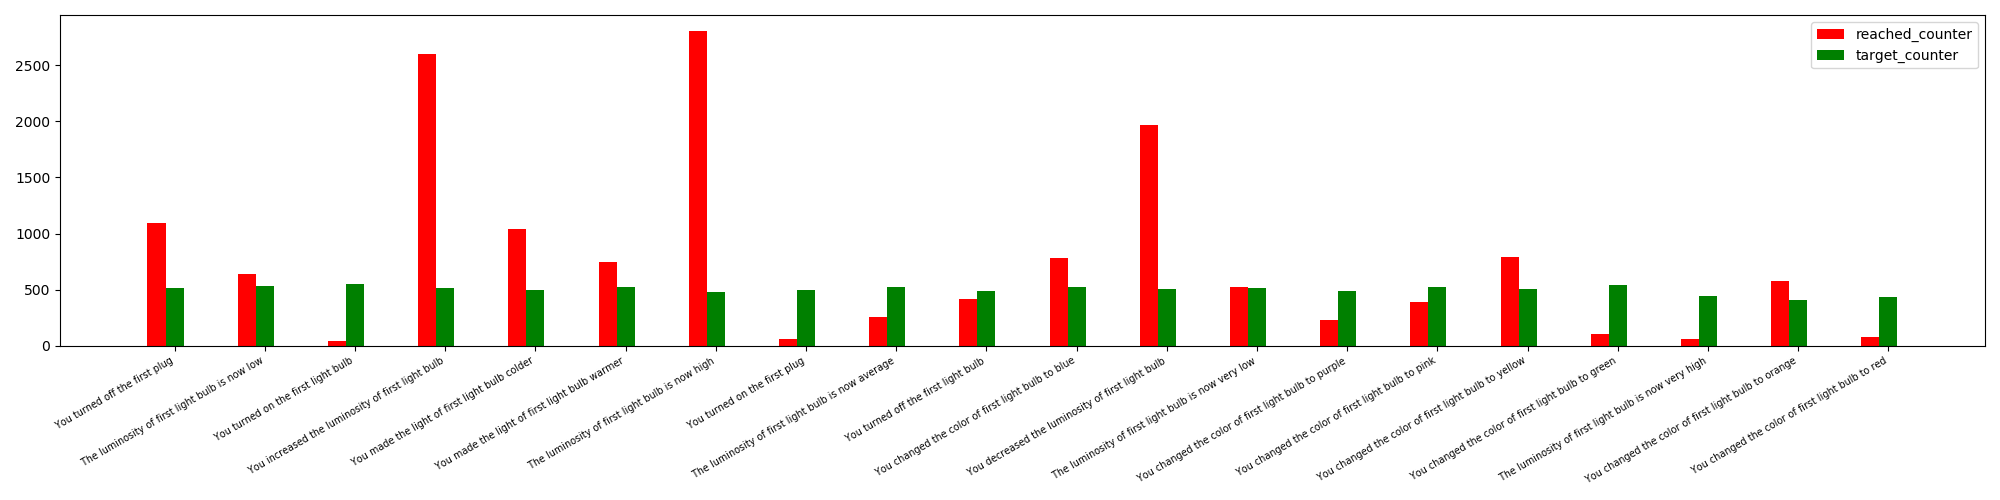

[Text(0, 0, 'You turned off the first plug'), Text(0, 0, 'The luminosity of first light bulb is now low'), Text(0, 0, 'You turned on the first light bulb'), Text(0, 0, 'You increased the luminosity of first light bulb'), Text(0, 0, 'You made the light of first light bulb colder'), Text(0, 0, 'You made the light of first light bulb warmer'), Text(0, 0, 'The luminosity of first light bulb is now high'), Text(0, 0, 'You turned on the first plug'), Text(0, 0, 'The luminosity of first light bulb is now average'), Text(0, 0, 'You turned off the first light bulb'), Text(0, 0, 'You changed the color of first light bulb to blue'), Text(0, 0, 'You decreased the luminosity of first light bulb'), Text(0, 0, 'The luminosity of first light bulb is now very low'), Text(0, 0, 'You changed the color of first light bulb to purple'), Text(0, 0, 'You changed the color of first light bulb to pink'), Text(0, 0, 'You changed the color of first light bulb to yellow'), Text(0, 0, 'You changed the color of firs

In [147]:
plot_goal_record(reached_counter, target_counter)

# Plot averaged simulation

In [47]:
# print(glob.glob(f'results/simulation_*'))
simulation_name = 'AttentionFlatQnet' #'DeepSetQnet' # 'NoAttentionFlatQnet' #  'AttentionFlatQnet'
folders = glob.glob(f'results/simulation_{simulation_name}*')
print(folders)

['results/simulation_AttentionFlatQnet_5', 'results/simulation_AttentionFlatQnet_9', 'results/simulation_AttentionFlatQnet_2', 'results/simulation_AttentionFlatQnet_10', 'results/simulation_AttentionFlatQnet_11', 'results/simulation_AttentionFlatQnet_4', 'results/simulation_AttentionFlatQnet_1', 'results/simulation_AttentionFlatQnet_8', 'results/simulation_AttentionFlatQnet_3', 'results/simulation_AttentionFlatQnet_6', 'results/simulation_AttentionFlatQnet_7']


In [48]:
flattened_records, reached_counters, target_counters, discovery_records, episodes = load_simulation_list(folders)
reached_averaged = {k: (np.round(np.mean(v)),np.round(np.std(v), 1)) for k,v in reached_counters.items()}
average_discovery = {k: (np.round(np.mean(v)),np.round(np.std(v), 1)) for k,v in discovery_records.items()}
average_flattened = {k: np.mean(v, 0) for k,v in flattened_records.items()}
std_flattened = {k: np.std(v, 0) for k,v in flattened_records.items()}

'results/simulation_AttentionFlatQnet_5/test_record.jbl'
done
'results/simulation_AttentionFlatQnet_9/test_record.jbl'
done
'results/simulation_AttentionFlatQnet_2/test_record.jbl'
done
'results/simulation_AttentionFlatQnet_10/test_record.jbl'
done
'results/simulation_AttentionFlatQnet_11/test_record.jbl'
done
'results/simulation_AttentionFlatQnet_4/test_record.jbl'
done
'results/simulation_AttentionFlatQnet_1/test_record.jbl'
done
'results/simulation_AttentionFlatQnet_8/test_record.jbl'
done
'results/simulation_AttentionFlatQnet_3/test_record.jbl'
done
'results/simulation_AttentionFlatQnet_6/test_record.jbl'
done
'results/simulation_AttentionFlatQnet_7/test_record.jbl'
done


<IPython.core.display.Javascript object>


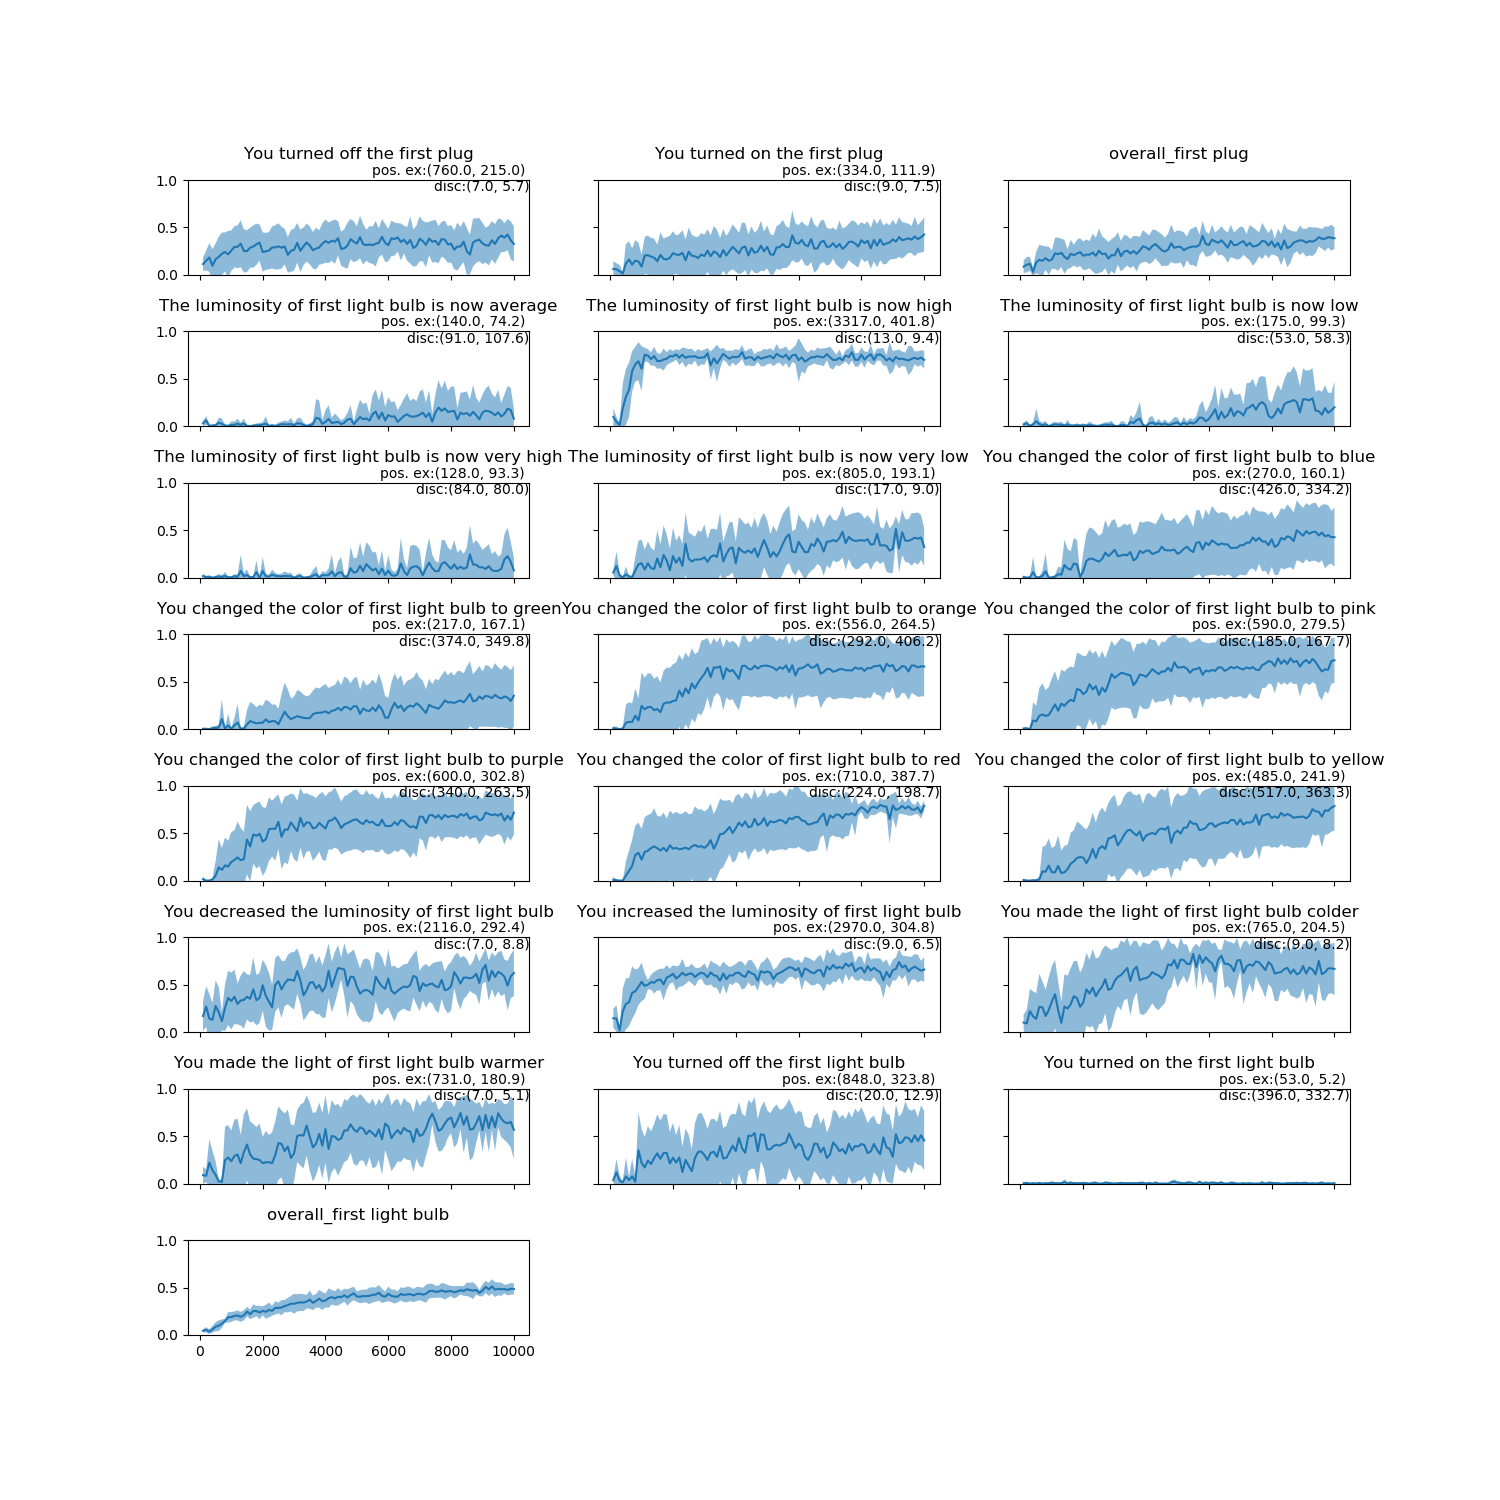

In [49]:
plot_average_success_rates(episodes, average_flattened, reached_averaged, std_record=std_flattened, iter_discovery=average_discovery)

# Usage

'results/second_round/simulation_NoAttentionFlatQnet_0/test_record.jbl'
done
'results/second_round/simulation_NoAttentionFlatQnet_1/test_record.jbl'
done


<IPython.core.display.Javascript object>


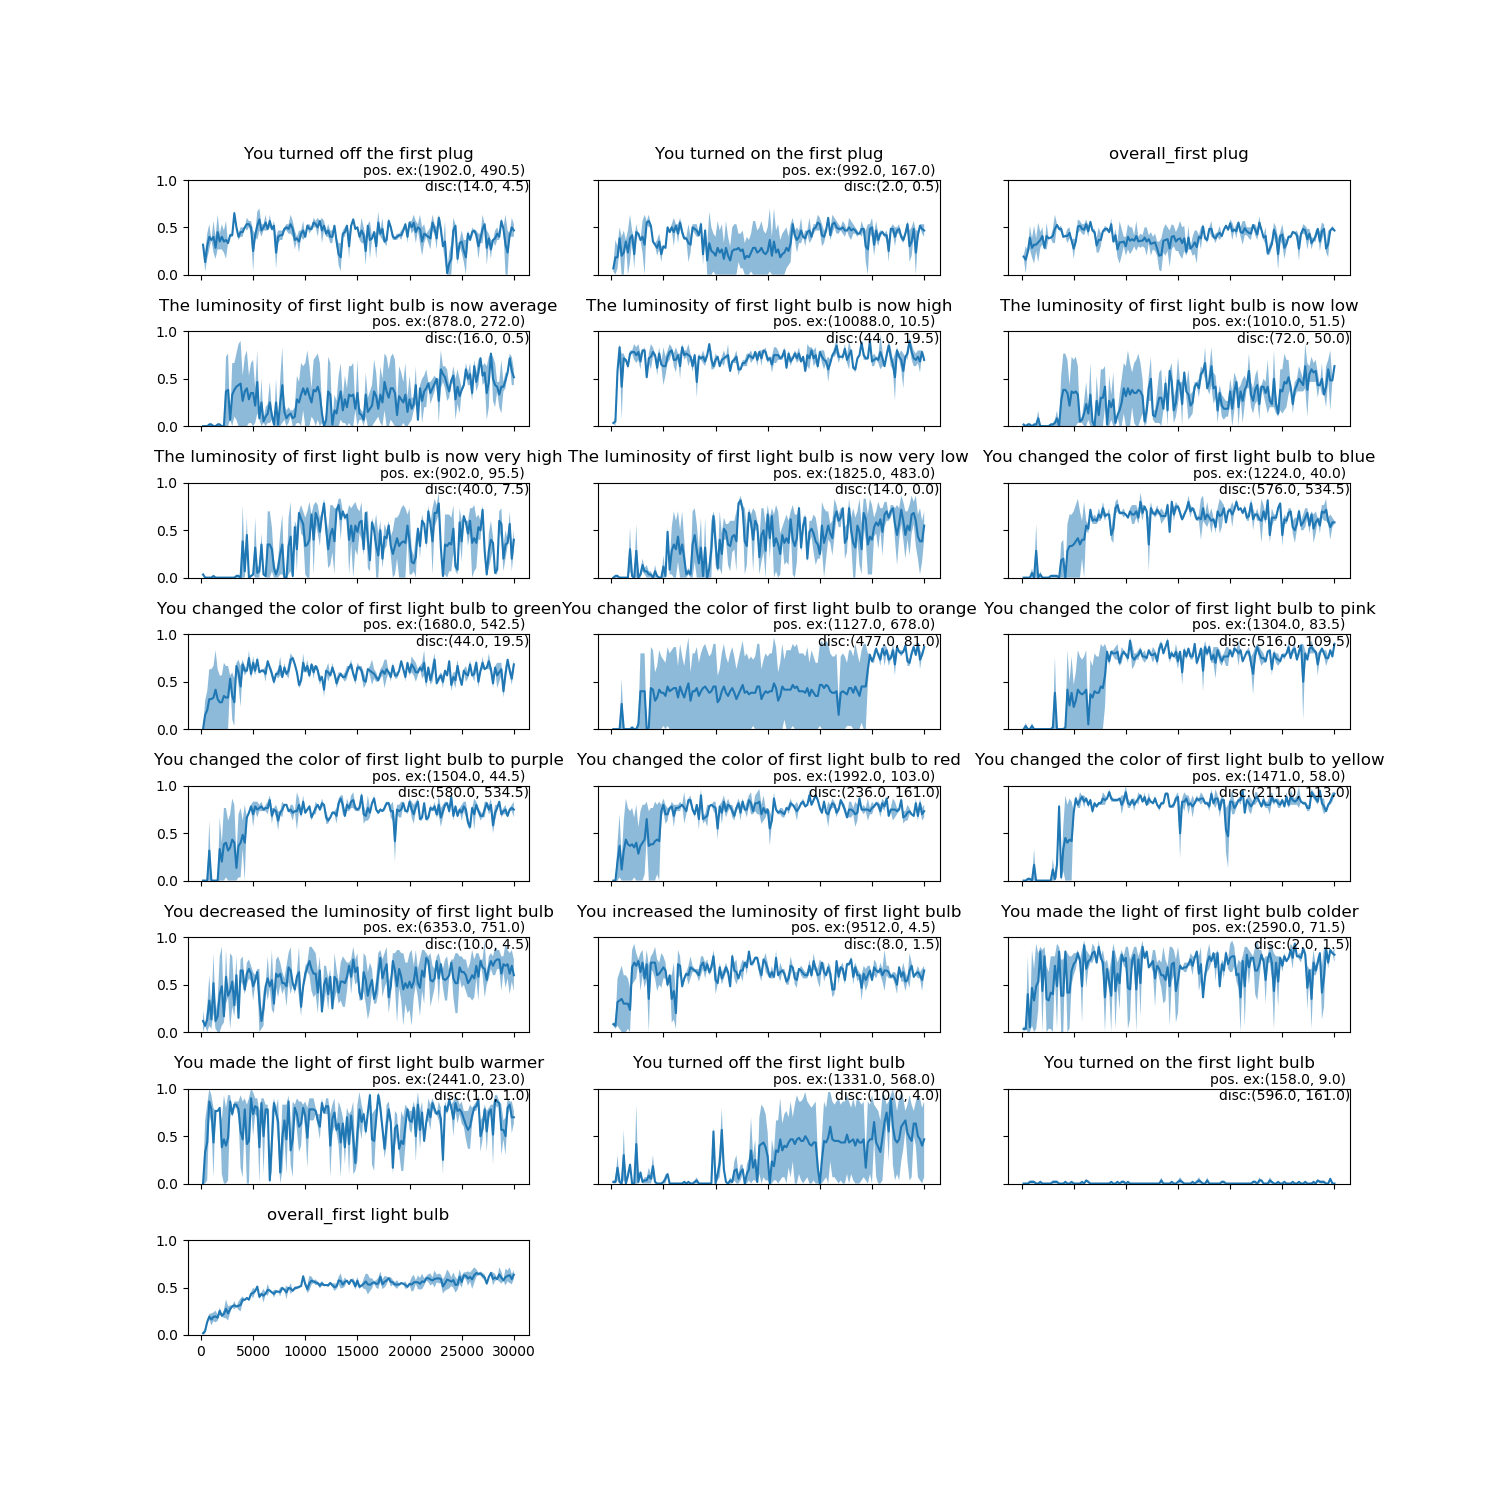

In [14]:
simulation_name = 'NoAttentionFlatQnet' #'DeepSetQnet' # 'NoAttentionFlatQnet' #  'AttentionFlatQnet'
folders = glob.glob(f'results/second_round/simulation_{simulation_name}*')
load_and_plot(folders)